## 포트폴리오 최적화

### 11-2-1 자료 분석

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
symbols = ['AAPL','MSFT','005930.KS','DB','GLD']  #애플,MS,삼성전자,도이치뱅크,금(ETF)
noa = len(symbols)

In [5]:
data = pd.DataFrame()
for sym in symbols:
    data[sym] = web.DataReader(sym,data_source='yahoo',end ='2019-9-12')['Close']
data.columns = symbols

<AxesSubplot:xlabel='Date'>

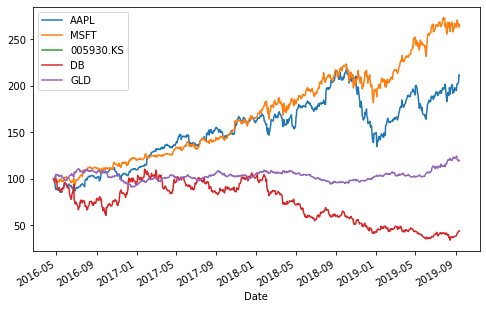

In [7]:
(data/data.iloc[0]*100).plot(figsize = (8,5))

In [8]:
rets = np.log(data/data.shift(1))  #로그수익률

In [9]:
#연수익률
rets.mean()*252

AAPL         0.220732
MSFT         0.288564
005930.KS    0.179706
DB          -0.242242
GLD          0.053554
dtype: float64

In [10]:
rets.cov()*252

,AAPL,MSFT,005930.KS,DB,GLD
AAPL,0.060060,0.031647,0.006289,0.025543,-0.003331
MSFT,0.031647,0.046841,0.001872,0.025015,-0.002895
005930.KS,0.006289,0.001872,0.068248,0.007264,-0.000804
DB,0.025543,0.025015,0.007264,0.152168,-0.010283
GLD,-0.003331,-0.002895,-0.000804,-0.010283,0.013234


### 11-2-2 기초 이론

매수 포지션'만' 가정 > 예산 전부 매수\
: 다섯개 합이 1이 되도록 rand 

In [11]:
weights = np.random.random(noa)
weights /= np.sum(weights)   #i.e weights = weights/np.sum(weights)

In [12]:
weights

array([0.08756377, 0.36753678, 0.21607894, 0.20477611, 0.1240444 ])

$r_i$(정규분포 이룬다 가정) : 미래 수익률 (vector)\
$\mu_i$ :각 자산의 기대 수익률 \
$w^T$ 비중행렬의 전치행렬, $\mu$ : 기대 수익률 vector \
**수익률 기대값 공식**\
    $\mu_p = E(\sum_I{w_ir_i})= w^T\mu$ \
**분산 기대값** \
$\sigma_{ij}  = E[(r_i-\mu_i)(r_j-\mu_j)]$ \
$\sigma_p = w^T\sigma w $

In [16]:
np.sum(rets.mean()*weights)*252 ,np.dot(weights.T,np.dot(rets.cov()*252,weights)) #포플 기대 수익률, 분산 기대값

(0.1212541620443016, 0.02355370477249303)

In [17]:
np.sqrt(np.dot(weights.T,np.dot(rets.cov()*252,weights))) #변동성 기대값

0.15347216285858822

In [20]:
#무작위 비중 벡터 생상하는 몬테카를로 Simulation
prets = []
pvols = []

for p in range(2500) :
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean()*weights)*252)
    pvols.append(np.sqrt(np.dot(weights.T,np.dot(rets.cov()*252,weights))))
    
prets = np.array(prets)
pvols = np.array(pvols)

샤프지수(Sharpe ratio) : $SR = \frac{(\mu_p-r_f)}{\sigma_p}$, 단순화를 위해 $r_f$ = 0 이라 가정

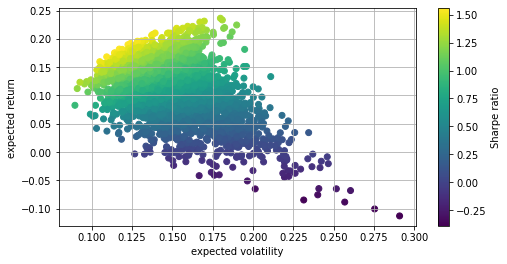

In [21]:
plt.figure(figsize = (8,4))
plt.scatter(pvols,prets,c=prets/pvols, marker = 'o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')

모든 비중이 좋은 성과 X\
이 때 같은 수익률에 대해 최소 위험이나 같은 위험 내 최대 수익을 얻는 포트폴리오의 집합 : 효율적 투자선(efficient frontier)

### 11-2-3 포트폴리오 최적화

In [22]:
def statistics(weights):
    ''' 포트폴리오 통계치 출력
    
    Parameter
    ====
    weights : array-like 포트폴리오 내의 증권 비중
    
    Return
    ====
    pret : float 포트폴리오 수익률 기댓값
    
    pvol : float 포트폴리오 변동성 기대값
    
    pret/pvol : float rf=0일 때 샤프지수
    '''
    weights = np.array(weights)
    pret = np.sum(weights*rets.mean())*252
    pvol = np.sqrt(np.dot(weights.T,np.dot(rets.cov()*252,weights)))
    
    return np.array([pret,pvol,pret/pvol])

In [23]:
#최적의 포트폴리오 = 최적화 문제
import scipy.optimize as sco

In [24]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [25]:
cons = ({'type':'eq','fun':lambda x : np.sum(x)-1})  #1:True,0:false >> np.sum(x)-1 대신  np.sum(x)==1 도 사용 가능

In [26]:
bnds = tuple((0,1) for x in range(noa))

In [28]:
noa*[1./noa,] #초기값 리스트

[0.2, 0.2, 0.2, 0.2, 0.2]

함수 입력시 최적 입력 변수값 뿐만 아닌 다양한 추가정보 출력 > opts에 저장

In [29]:
%%time
opts = sco.minimize(min_func_sharpe,noa*[1./noa,],method = 'SLSQP',bounds = bnds, constraints= cons)

Wall time: 72.8 ms


In [30]:
opts #결과값(샤프지수 최대화)

     fun: -1.61656349661806
     jac: array([ 1.06211007e-03,  7.81163573e-04, -5.48854470e-04,  3.34528235e+00,
       -6.96852803e-04])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([3.70948865e-02, 4.10453420e-01, 1.68622198e-01, 9.87030548e-16,
       3.83829496e-01])

In [31]:
opts['x'].round(3)   #4개만 투자

array([0.037, 0.41 , 0.169, 0.   , 0.384])

In [32]:
statistics(opts['x'].round(3))  #수익률 기대값 17,7%, 변동성 10.9%, 최적 샤프 지수 1.62

array([0.1774131 , 0.1097471 , 1.61656292])

In [33]:
#분산 최소화('i.e변동성 최소화')
def min_func_variance(weights):
    return statistics(weights)[1]**2

In [34]:
optv = sco.minimize(min_func_variance,noa*[1./noa,],method = 'SLSQP',bounds = bnds, constraints= cons)
optv

     fun: 0.007451450522665382
     jac: array([0.01495654, 0.01543385, 0.01453957, 0.01482868, 0.01485214])
 message: 'Optimization terminated successfully'
    nfev: 72
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([0.05619053, 0.13285828, 0.09935292, 0.05694867, 0.6546496 ])

In [35]:
optv['x'].round(3) #이번에는 전부 적용 (변동성 최소화)

array([0.056, 0.133, 0.099, 0.057, 0.655])

In [36]:
statistics(optv['x'].round(3))

array([0.08980068, 0.08632285, 1.04028861])

### 11-2-4 효율적 투자선

목표 수익률 고정시키고, 그 수익률 달성하면서 최소의 변동성 가지는 포트폴리오 비중 계산 방법.\
tret : 목표 수익률

In [37]:
cons = ({'type':'eq','fun':lambda x: statistics(x)[0]-tret},
       {'type':'eq','fun':lambda x: np.sum(x)-1})
bnds = tuple((0,1) for x in weights)

In [38]:
def min_func_port(weights):
    return statistics(weights)[1] #변동성 값 반환

In [39]:
%%time
trets = np.linspace(0.0,0.25,50)
tvols = []
for tret in trets:
    cons = ({'type':'eq','fun':lambda x: statistics(x)[0]-tret},
            {'type':'eq','fun':lambda x: np.sum(x)-1})
    res =sco.minimize(min_func_port,noa*[1./noa,],method='SLSQP',bounds= bnds, constraints= cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

Wall time: 3.93 s


#tret을 반복하면 제한 조건이 계속 변하기 떄문에 조건 갱신해줘야함

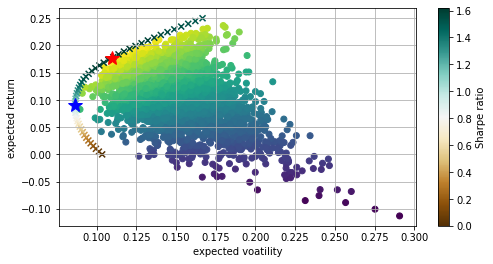

In [58]:
#최적화 결과
plt.figure(figsize = (8,4))
plt.scatter(pvols,prets,c=prets/pvols,marker = 'o') #무작위 포플( rf = 0)
plt.scatter(tvols,trets,c = trets/tvols, marker = 'x',cmap = plt.cm.BrBG) #효율적 투자선 > 특정 위험수준에서 가장 높은 수익률 가짐
plt.plot(statistics(opts['x'])[1],statistics(opts['x'])[0],'r*',markersize = 15.0) #최대 샤프지수 포폴
plt.plot(statistics(optv['x'])[1],statistics(optv['x'])[0],'b*',markersize = 15.0) #최소분산포트폴리오
plt.grid(True)
plt.xlabel('expected voatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')

### 11-2-5 자본시장선(CAPM)
효울적 포트폴리오 결정 후 무위험자산 추가\
: 무위험 자산에 투자된 비중을 조정하면 무위험 자산과 효율적 포트폴리오 사이 직선으로 나타나는 위험= 수익률 집합 중 하나 선택 가능\
최적의 투자? : rf 값에 접하는 접선에 포함된 포트폴리오

효율적 투자선 함수형태와 1차 도함수 필요 > 큐빅 스플라인 보간법 필요(9장에서 했었음)

In [56]:
import scipy.interpolate as sci

In [60]:
ind =np.argmin(tvols) #효율적 투자선 위에 있는 포폴만 선택 (trets이 오름차순이므로 결국 위에 볼록한 부분만 남게됨 : 기울기 양수부분)
evols = tvols[ind:]
erets = trets[ind:]

In [63]:
tck = sci.splrep(evols,erets) #보간법

In [64]:
def f(x):
    ''' 효율적 투자선 함수 (스플라인 근사)'''
    return sci.splev(x,tck,der= 0)
def df(x):
    ''' 효율적 투자선의 1차 도함수 '''
    return sci.splev(x,tck,der = 1)

직선 묘사 함수 t(x)= a+bx\
t(x)가 만족해야 할 세가지 조건\
$ t(0) = r_f <=> a = r_f $\
$ t(x) = f(x) <=> a+bx = f(x)$ f(x) :효율적 투자선\
$ t'(x) = f'(x) <=> b = f'(x) $\
즉, 기울기는 접점, 상수항은 무위험이자율

In [65]:
def equations(p,rf = 0.01):
    '''자본시장선 조건 함수 정의
    p =(a,b,x)
    
    '''
    eq1 = rf-p[0]
    eq2 = rf+p[1]*p[2]-f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1,eq2,eq3

In [67]:
opt = sco.fsolve(equations,[0.01,0.5,0.15])
opt

array([0.01      , 1.52687131, 0.11339103])

In [68]:
np.round(equations(opt),6) #opt 대입시 세 값 모두 0이 됨

array([ 0., -0., -0.])

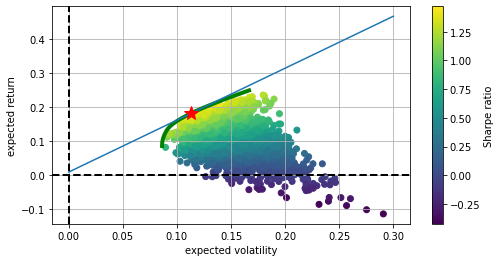

In [72]:
#결과 시각화
plt.figure(figsize = (8,4))
plt.scatter(pvols,prets,c = (prets-0.01)/pvols,marker = 'o') #무작위 포폴
plt.plot(evols,erets,'g',lw = 4.0) # 효율적 투자선
cx = np.linspace(0.0,0.3)
plt.plot(cx,opt[0]+opt[1]*cx,lw = 1.5) #자본시장선
plt.plot(opt[2],f(opt[2]),'r*',markersize = 15.0)
plt.grid(True)
plt.axhline(0,color ='k',ls ='--',lw = 2.0)
plt.axvline(0,color = 'k',ls = '--',lw = 2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')

In [73]:
cons = ({'type':'eq','fun':lambda x: statistics(x)[0]-tret},
        {'type':'eq','fun':lambda x: np.sum(x)-1})
res =sco.minimize(min_func_port,noa*[1./noa,],method='SLSQP',bounds= bnds, constraints= cons)

res['x'].round(3) #자본시장선에 접하는 최적 포트폴리오의 비중 3개만 포함됨.

array([0.   , 0.71 , 0.234, 0.   , 0.056])